**Aims:** Extract results from the CRISPRa/i screen processing outputs and generate plots for the manuscript.

- [x] PCA plot of CRISPRi screens – Fig 1-B and Fig 2-A
- [x] PCA plot of CRISPRa screens – Fig S1a
- [ ] I can do the upset plot in Fig S1b but can you provide the phenotype table (we also need this table for the supplement anyway - Table S2?)
- [ ] Can you do a scatter plot to replace the one in Fig S1c?

<!-- 

    T0: First timepoint 
    (Time Zero, after selection of cells with sgRNA library, and starting point of drug dosing)
    DMSO: DMSO treated 
    Pi: PARP inhibitor (olaparib; AZD2281)
    Ri: ATR inhibitor (AZD6738)
    Wi: WEE1 inhibitor (AZD1775)
    Mi: ATM inhibitor (AZD0156)
    Ki: DNAPK inhibitor (AZD7648)


    PiRi: PARP inhibitor + ATR inhibitor
    PiWi: PARP inhibitor + WEE1 inhibitor
    PiMi: PARP inhibitor + ATM inhibitor
    PiKi: PARP inhibitor + DNAPK inhibitor 
-->

- https://docs.bokeh.org/en/0.10.0/docs/user_guide/interaction.html#id15

### Setup python session

In [33]:
# !pip uninstall -y screenpro2
# !pip install git+https://github.com/ArcInstitute/screenpro2.git@dev
# # !pip install ScreenPro2

In [1]:
from glob import glob

import numpy as np
import pandas as pd 
import anndata as ad
import scanpy as sc

import screenpro as scp
import blitzgsea as blitz

import matplotlib.pyplot as plt

sc.settings.set_figure_params(
    dpi=500, format='svg', frameon=False, figsize=(3, 3), color_map='RdGy', 
    facecolor='white', 
    vector_friendly=True
)

In [2]:
import datetime

import matplotlib
import matplotlib.ticker as ticker

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import font_manager as fm
from matplotlib import rcParams, rc_context

from screenpro.plotting._utils import almost_black, dark2


matplotlib.use('cairo')

font_files = fm.findSystemFonts(fontpaths='/home/abea/miniconda3/envs/screenpro2/fonts/', fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)


# {f.name for f in matplotlib.font_manager.fontManager.ttflist}

rcParams['font.sans-serif'] = 'Helvetica'
rcParams['font.family'] = ['Helvetica']
rcParams['figure.dpi'] = 140

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [24]:
drug_names = {
    'DMSO': 'DMSO', # Vehicle
    'Pi': 'PARPi',
    'Ri': 'ATRi',
    'Wi': 'WEE1i',
    'Mi': 'ATMi',
    'Ki': 'DNAPKi',
    'PiRi': 'PARPi+ATRi',
    'PiWi': 'PARPi+WEE1i',
    'PiMi': 'PARPi+ATMi',
    'PiKi': 'PARPi+DNAPKi'
}

In [46]:
### get result tables: gene level scores with out negative controls
def getAnnotatedTables(screen, threshold):
    return dict([
        (phenotype_name, 
         screen.getPhenotypeScores(
             run_name='compare_guides',phenotype_name=phenotype_name,threshold=threshold, pvalue_col='ttest pvalue'
         )#.query('target!="negative_control"').set_index(['target','transcript'])
         )
        for phenotype_name in screen.listPhenotypeScores(run_name='compare_guides')
    ])


### get annotated result table: rho scores
def get_annotated_result_table(screen,threshold=6):
    return pd.concat(dict([
        (
            k.replace(k.split(':')[1].split('_vs_')[0], drug_names[k.split(':')[1].split('_vs_')[0]]), 
            table
        ) for k, table in getAnnotatedTables(screen, threshold=threshold).items()
        if 'rho' in k or 'gamma' in k
    ]),axis=1).dropna()

In [61]:
### pathway analysis
pager_dir = "/home/abea/tools/pager/"
pager_annotation_path = '/home/abea/tools/pager/annotations/human'

c5_gobp_gmt = blitz.enrichr.read_gmt(
    f'{pager_annotation_path}/msigdb_v7.4_c5.go.bp/c5.go.bp.v7.4.symbols.gmt'
)


def run_rho_gsea_directional(df,var_col,gmt,min_size=15,max_size=150):
    signature = df.query('target!="negative_control"').set_index('target')[var_col].reset_index().copy()

    result = blitz.gsea(
        signature=signature,
        library=gmt,
        min_size=min_size,
        max_size=max_size,
        verbose=True
    )
    
    return signature, result

___

### Load Data
Load Screen Processing guide level and gene level result tables.

In [41]:
crispra_v2_screen = scp.load._read_screen_pkl('screens/A549_CRISPRa_v2_screens')
crispri_v2_screen = scp.load._read_screen_pkl('screens/A549_CRISPRi_v2_screens')

___

In [48]:
crispra_v2_screen_result_tables = get_annotated_result_table(crispra_v2_screen)
crispri_v2_screen_result_tables = get_annotated_result_table(crispri_v2_screen)

/home/abea/miniconda3/envs/screenpro2/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Pathway analysis

run gsea

In [62]:
crispra_v2_screen_gsea_results = {}

for drug_name in crispra_v2_screen_result_tables.columns.get_level_values(0).unique():

    if 'gamma' not in drug_name:
        
        print(drug_name)
        
        _, res = run_rho_gsea_directional(
            crispra_v2_screen_result_tables[drug_name], 
            var_col='score', 
            gmt=c5_gobp_gmt
        )

        crispra_v2_screen_gsea_results[drug_name] = res

rho:PARPi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5920.44it/s]


rho:ATRi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5938.49it/s]


rho:PARPi+ATRi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5969.19it/s]


rho:WEE1i_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5987.59it/s]


rho:PARPi+WEE1i_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5964.97it/s]


In [63]:
crispri_v2_screen_gsea_results = {}

for drug_name in crispri_v2_screen_result_tables.columns.get_level_values(0).unique():

    if 'gamma' not in drug_name:
        
        print(drug_name)

        _, res = run_rho_gsea_directional(
            crispri_v2_screen_result_tables[drug_name], 
            var_col='score', 
            gmt=c5_gobp_gmt
        )

        crispri_v2_screen_gsea_results[drug_name] = res

rho:PARPi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5735.84it/s]
/home/abea/miniconda3/envs/screenpro2/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


rho:ATRi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5789.27it/s]
/home/abea/miniconda3/envs/screenpro2/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


rho:PARPi+ATRi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5724.23it/s]
/home/abea/miniconda3/envs/screenpro2/lib/python3.11/site-packages/statsmodels/stats/multitest.py:164: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


rho:ATMi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5285.46it/s]


rho:PARPi+ATMi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5711.41it/s]


rho:WEE1i_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5488.23it/s]


rho:PARPi+WEE1i_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5581.91it/s]


rho:DNAPKi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5431.28it/s]


rho:PARPi+DNAPKi_vs_DMSO


Enrichment : 100%|██████████| 7481/7481 [00:01<00:00, 5506.01it/s]


### PCA plot
Using guide level fold change values, generate PCA plot.

In [11]:
crispri_v2_screen.buildPhenotypeData(run_name='compare_reps', db_rate_col=None)

crispri_v2_screen.pdata.obs['replicate'] = crispri_v2_screen.pdata.obs.index.str[-1]#.astype(int)
crispri_v2_screen.pdata.obs['score_tag'] = crispri_v2_screen.pdata.obs.index.str.split('::').str[0].str.split(':').str[0]
crispri_v2_screen.pdata.obs['comparison'] = crispri_v2_screen.pdata.obs.index.str.split('::').str[0].str.split(':').str[1]

In [12]:
crispri_v2_screen_pdata = crispri_v2_screen.pdata[crispri_v2_screen.pdata.obs.score_tag.isin(['rho'])].copy()
crispri_v2_screen_pdata.obs['treatment'] = crispri_v2_screen_pdata.obs['comparison'].apply(lambda x: drug_names[x.replace('_vs_DMSO','')]).to_list()

___

PCA for CRISPRi v2 screens (rho values) for mono treatments

In [13]:
crispri_v2_screen_pdata_mono = crispri_v2_screen_pdata[
    ~crispri_v2_screen_pdata.obs.treatment.str.contains('\+')
].copy()

In [14]:
crispri_v2_screen_pdata_mono.obs['treatment'] = pd.Categorical(
    crispri_v2_screen_pdata_mono.obs['treatment'], categories=[
    'ATRi',
    'ATMi',
    'DNAPKi',
    'WEE1i',
    'PARPi',
])

In [15]:
sc.pp.regress_out(crispri_v2_screen_pdata_mono, ['replicate'])

In [16]:
sc.pp.pca(crispri_v2_screen_pdata_mono)

Fig. 1-B

In [17]:
sc.pl.pca(crispri_v2_screen_pdata_mono,size=400, color='treatment', palette='Paired', frameon=True,show=False)
plt.savefig("plots/Fig-1B.pdf",bbox_inches="tight",format='pdf')

___

PCA for CRISPRi v2 screens (rho values) for all treatments

In [18]:
crispri_v2_screen_pdata.obs['treatment'] = pd.Categorical(crispri_v2_screen_pdata.obs['treatment'], categories=[
    'ATRi',
    'PARPi+ATRi',
    'ATMi',
    'PARPi+ATMi',
    'DNAPKi',
    'PARPi+DNAPKi',
    'WEE1i',
    'PARPi+WEE1i',
    'PARPi',
])

In [19]:
sc.pp.regress_out(crispri_v2_screen_pdata, ['replicate'])

In [20]:
sc.pp.pca(crispri_v2_screen_pdata)

Fig. 2-A

In [21]:
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.pca(crispri_v2_screen_pdata,size=400, color='treatment', palette='tab20c', frameon=True, show=False)
    plt.savefig("plots/Fig-2A.pdf", bbox_inches="tight",format='pdf')

___

#### CRISPRa

In [22]:
crispra_v2_screen.buildPhenotypeData(run_name='compare_reps', db_rate_col=None)

crispra_v2_screen.pdata.obs['replicate'] = crispra_v2_screen.pdata.obs.index.str[-1]#.astype(int)
crispra_v2_screen.pdata.obs['score_tag'] = crispra_v2_screen.pdata.obs.index.str.split('::').str[0].str.split(':').str[0]
crispra_v2_screen.pdata.obs['comparison'] = crispra_v2_screen.pdata.obs.index.str.split('::').str[0].str.split(':').str[1]

In [23]:
crispra_v2_screen_pdata = crispra_v2_screen.pdata[crispra_v2_screen.pdata.obs.score_tag.isin(['rho'])].copy()
crispra_v2_screen_pdata.obs['treatment'] = crispra_v2_screen_pdata.obs['comparison'].apply(lambda x: drug_names[x.replace('_vs_DMSO','')]).to_list()

PCA for CRISPRa v2 screens (rho values) for all treatments

In [24]:
crispra_v2_screen_pdata.obs

,replicate,score_tag,comparison,treatment
rho:Pi_vs_DMSO::replicate_1,1,rho,Pi_vs_DMSO,PARPi
rho:Ri_vs_DMSO::replicate_1,1,rho,Ri_vs_DMSO,ATRi
rho:PiRi_vs_DMSO::replicate_1,1,rho,PiRi_vs_DMSO,PARPi+ATRi
rho:Wi_vs_DMSO::replicate_1,1,rho,Wi_vs_DMSO,WEE1i
rho:PiWi_vs_DMSO::replicate_1,1,rho,PiWi_vs_DMSO,PARPi+WEE1i


In [25]:
crispra_v2_screen_pdata.obs['treatment'] = pd.Categorical(crispra_v2_screen_pdata.obs['treatment'], categories=[
    'ATRi',
    'PARPi+ATRi',
    'WEE1i',
    'PARPi+WEE1i',
    'PARPi',
])

In [26]:
# sc.pp.regress_out(crispra_v2_screen_pdata, ['replicate'])

In [27]:
sc.pp.pca(crispra_v2_screen_pdata)

Fig S1a

In [28]:
sc.pl.pca(crispra_v2_screen_pdata,size=400, color='treatment', palette='Paired', frameon=True, show=False)
plt.savefig("plots/Fig-S1A.pdf", bbox_inches="tight",format='pdf')

### Scatter plots

In [43]:
def plot_score_scatters(screen, title, untreated='vehicle', treated='DNAPKi'):
    fig, axes = plt.subplots(ncols=3,
                             figsize=(6.2,3), 
                             gridspec_kw={'wspace': 0.4, 'left': 0.12,'top':.8,'bottom':.3}, 
                             # sharey=True
                            )
    scp.pl.plotReplicateScatter(axes[0], screen.pdata, 
                                f'gamma:{untreated}_vs_T0::replicate_1',
                                f'gamma:{untreated}_vs_T0::replicate_2',
                                title='gamma',
                                 # min_val=-1,max_val=1,
                                 log_transform=False)
    scp.pl.plotReplicateScatter(axes[1], screen.pdata, 
                                f'tau:{treated}_vs_T0::replicate_1',
                                f'tau:{treated}_vs_T0::replicate_2',
                                title='tau',
                                 # min_val=-1,max_val=1,
                                 log_transform=False)
    scp.pl.plotReplicateScatter(axes[2], screen.pdata, 
                                f'rho:{treated}_vs_{untreated}::replicate_1',
                                f'rho:{treated}_vs_{untreated}::replicate_2',
                                title='rho',
                                 # min_val=-1,max_val=1,
                                 log_transform=False)
    
    
    for ax in axes: 
        ax.tick_params(width=0.5)
        for i in ax.spines.values(): i.set_linewidth(0.5)
        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
            item.set_fontsize(8)
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(6)
        
        # ax.set_xticks(list(map(lambda x: x/10.0, range(-10, 11, 5))))
        # ax.set_xticks(list(map(lambda x: x/10.0, range(-10, 11, 5))))
    
    fig.suptitle(title,fontsize=12)
    
    return fig

draw scatter plots

In [44]:
figs_score_scatters = {}

for drug_id, drug_name in drug_names.items():

    figs_score_scatters[drug_name] = plot_score_scatters(
        crispri_v2_screen, drug_name, untreated='DMSO', treated=drug_id
    )

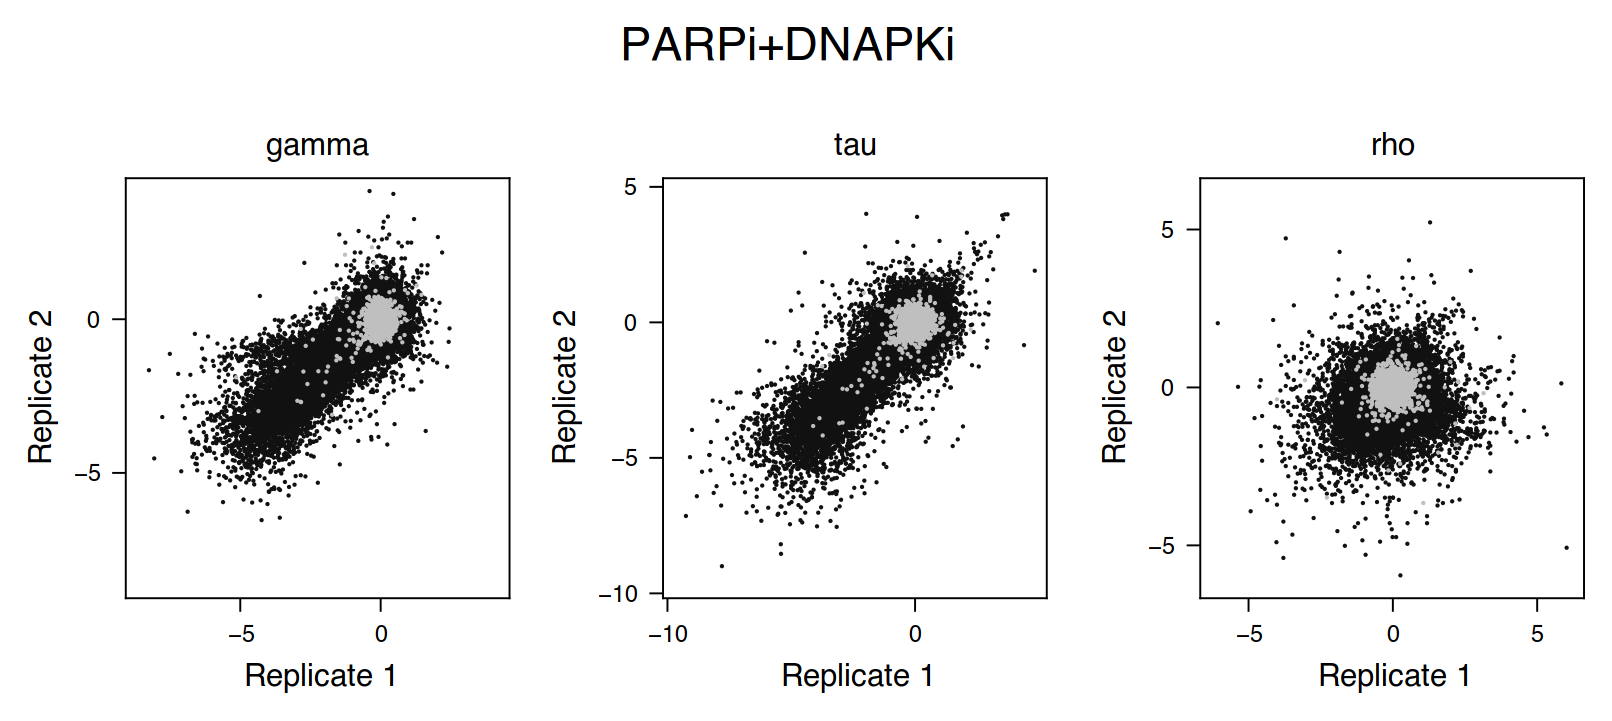

In [46]:
figs_score_scatters

save

In [47]:
with PdfPages('plots/A549_CRISPRi_score_scatters.pdf') as pdf:

    for fig in figs_score_scatters.values():
        # Save the plot as a PDF
        pdf.savefig(fig, dpi=500)  # saves the current figure into a pdf page

    d = pdf.infodict()
    d['Title'] = 'ScreenPro2 plots'
    d['ModDate'] = datetime.datetime.today()

### up-set plot

In [50]:
import upsetplot as up

In [9]:
hits_dict = dict(
    [
        (drug_names[res_name.split(':')[1].split('_vs_')[0]], res[res['combined_score'].le(-6)].index.to_list())
        # (res_name, res['score'])
        for res_name, res in result_tables.items()
    ]
)

hits_data = up.from_contents(hits_dict).reset_index().set_index('id')

In [10]:
hits_data[hits_data.all(axis=1)].index.to_list()

['CDK12', 'MCPH1', 'PRDX1', 'RAD9A', 'RFC5', 'XRCC3']

#### Fig-1C

In [26]:
%%time
fig = plt.figure(figsize=(3, 3), dpi=300)

u = up.UpSet(
    up.from_contents(
        dict([(treatment, hits) for treatment, hits in hits_dict.items() if '+' not in treatment])
    ),
    subset_size='count',
    sort_categories_by  = 'cardinality',
    # sort_by='cardinality',
    # orientation='vertiCil',
    show_counts='%d',
    other_dots_color=0.001, 
    # shading_color=0, 
    # with_lines=False,
    min_degree=1,
    # min_subset_size = 4,
    element_size=30
    
)

u.style_subsets(
    max_degree = 10,
    facecolor = 'grey',
)


u.style_subsets(
    # present="PARPi",
    min_degree = 5 ,
    # absent="cat1", 
    facecolor="lightblue",
    edgecolor="darkgreen",
    linewidth=2
)

u.style_subsets(
    # present="Pi dn", 
    max_degree = 1 ,
    # absent="cat1", 
    facecolor="lightblue",
    edgecolor="blue",
    linewidth=2
)

u.plot(fig = fig)

                    
# 
fig.suptitle('CRISPRi rho scores (treated vs. untreated)\nSensitivity hits',fontsize=12)

plt.savefig('Fig-1C.pdf')

plt.show()

CPU times: user 237 ms, sys: 3.97 ms, total: 241 ms
Wall time: 241 ms


#### Fig-2C

In [27]:
%%time
fig = plt.figure(figsize=(3, 3), dpi=300)

u = up.UpSet(
    up.from_contents(
        dict([(treatment, hits) for treatment, hits in hits_dict.items() if 'PARPi' in treatment])
    ),
    subset_size='count',
    sort_categories_by  = 'cardinality',
    # sort_by='cardinality',
    # orientation='vertiCil',
    show_counts='%d',
    other_dots_color=0.001, 
    # shading_color=0, 
    # with_lines=False,
    min_degree=1,
    # min_subset_size = 4,
    element_size=30
    
)

u.style_subsets(
    max_degree = 10,
    facecolor = 'grey',
)


u.style_subsets(
    # present="PARPi",
    min_degree = 5 ,
    # absent="cat1", 
    facecolor="lightblue",
    edgecolor="darkgreen",
    linewidth=2
)

u.style_subsets(
    # present="Pi dn", 
    max_degree = 1 ,
    # absent="cat1", 
    facecolor="lightblue",
    edgecolor="blue",
    linewidth=2
)

u.plot(fig = fig)

                    
# 
fig.suptitle('CRISPRi rho scores (treated vs. untreated)\nSensitivity hits',fontsize=12)

plt.savefig('Fig-2B.pdf')

plt.show()

CPU times: user 95.9 ms, sys: 4.03 ms, total: 99.9 ms
Wall time: 99.4 ms


### Rank plots

In [11]:
def draw_rank_plot(df, col, ax, sen_hits, q_thr=0.05):
    
    _, _ = scp.pl._rank.rank_plot(
        df,
        col,
        ylabel='',
        highlight_values_dict={
            # '#3182bd': {
            '#482677': {
                'genes': sen_hits,
                'text': True
            },
        #     'black': {
        #         'genes': [
        #             g for g in p53_targets 
        #             if g in df[sensitivity_hit | resistant_hit]['target'].to_list()
        #         ],
        #         'text': False
        #     },
        #     # 'darkblue': {
        #     #     'genes': ['CHD8', 'SOX9', 'ACTB','RNF4', 'VPS37A','MYBL2'],
        #     #     'text': True
        #     # },
        },
        ax=ax,
        highlight_size_factor=20,
        dot_size=.1,
        txt_font_size=6,
        title=col,
        # rasterized=True,
    )
    
    ax.set_xlim(-3000,21000)
    ax.set_xticks(np.arange(0, 20001, 5000))

    ax.tick_params(width=1)
    for i in ax.spines.values(): i.set_linewidth(1)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    for item in ([ax.title]):
        item.set_fontsize(9)
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(6)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(6)
    
    # ax.hlines(df[col].quantile(q=q_thr), 0, 1, transform=ax.get_yaxis_transform(), linewidth=1, linestyles='-', colors='#3182bd')
    # ax.hlines(df[col].quantile(q=1-q_thr), 0, 1, transform=ax.get_yaxis_transform(), linewidth=1, linestyles='-', colors='#de2d26')

___

In [12]:
hits_common_sen = hits_data[hits_data.all(axis=1)].index.to_list()

In [13]:
label_sen_hits = {
    'PARPi': ['RNF8','XRCC2','RBBP8','BRCA1','RAD51D','MDC1','LIG1'] + hits_common_sen,
    'ATRi':  ['RNF8','XRCC2','RBBP8','BRCA1','RAD51D','MDC1','LIG1'] + hits_common_sen,
    'ATMi':  ['RNF8','XRCC2','RBBP8','BRCA1','RAD51D','MDC1','LIG1'] + hits_common_sen,
    'WEE1i': ['RNF8','XRCC2','RBBP8','BRCA1','RAD51D','MDC1','LIG1','PKMYT1'] + hits_common_sen,
    'DNAPKi':['RNF8','XRCC2','RBBP8','BRCA1','RAD51D','MDC1','LIG1'] + hits_common_sen,
}

In [14]:
# result_tables['rho:Wi_vs_DMSO'].sort_values('combined_score')

/home/abea/miniconda3/envs/screenpro2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/abea/miniconda3/envs/screenpro2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/abea/miniconda3/envs/screenpro2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/abea/miniconda3/envs/screenpro2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/abea/miniconda3/envs/screenpro2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1266: User

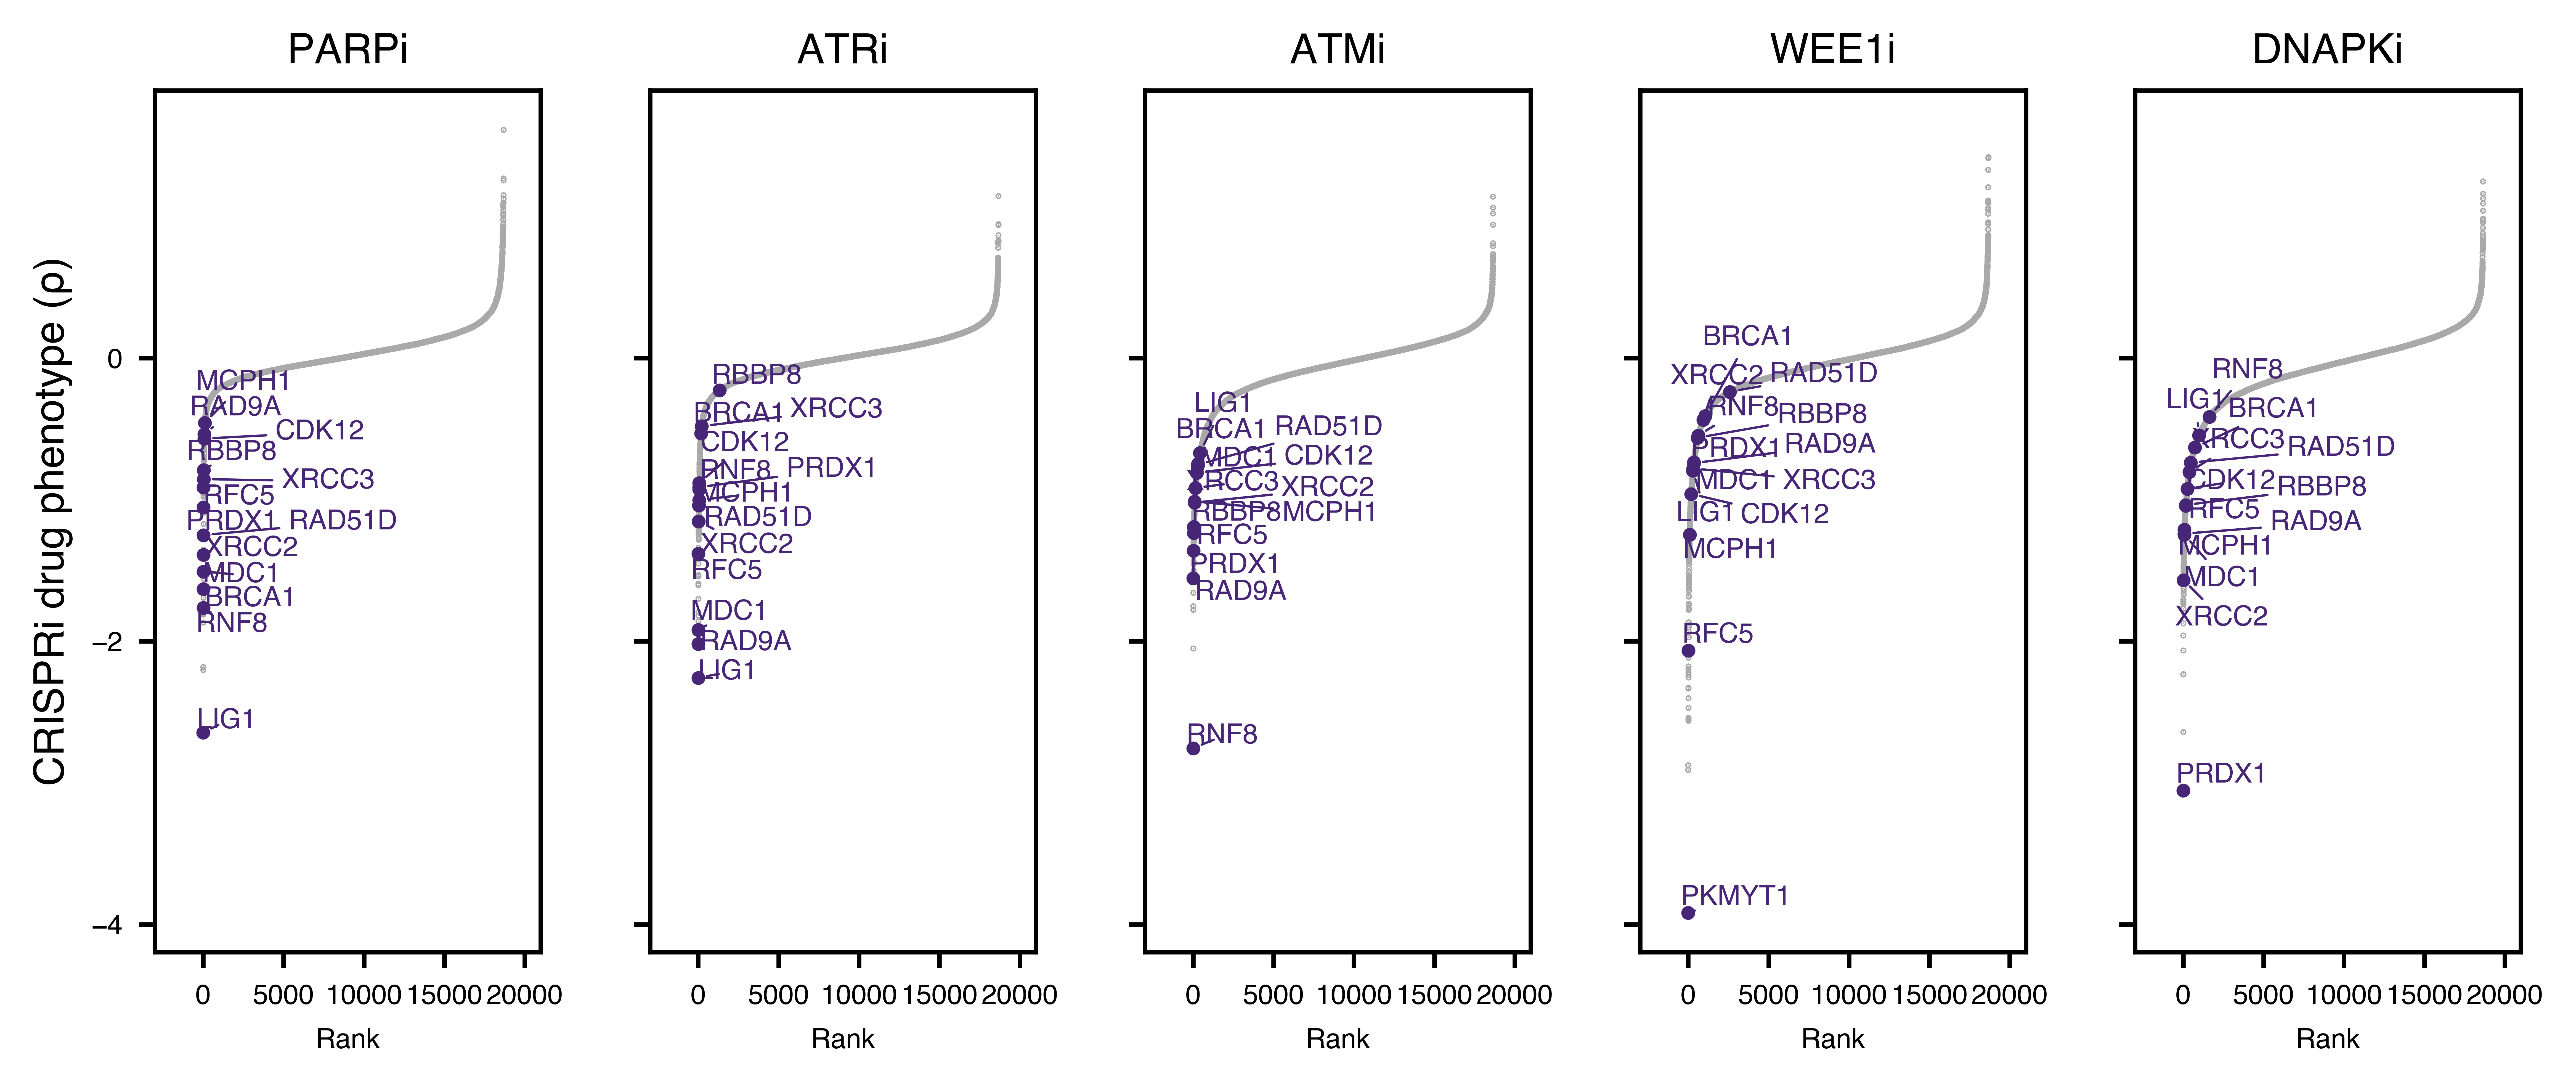

In [15]:
%matplotlib inline
fig, axes = plt.subplots(1,5,figsize=(8, 3.5), dpi=600,sharey=True)

i = 0

for res_name in result_tables.keys():
    treatment = drug_names[res_name.split(':')[1].split('_vs_')[0]]

    if '+' not in treatment:
        ax = axes[i]
        draw_rank_plot(
            result_tables[res_name].reset_index(names='target'), 'score', ax,
            sen_hits=label_sen_hits[treatment]
        )
        ax.set_title(treatment,fontsize=9)
        i=i+1


axes[0].set_ylabel('CRISPRi drug phenotype (ρ)', fontsize=9)

# plt.gcf().set_size_inches(7, 3)  # width, height in inches

# Save the plot as a PDF
fig.tight_layout()
plt.savefig('Fig-1D.pdf', dpi=600)

### spider plot

In [16]:
## Spider plot
# https://www.pythoncharts.com/matplotlib/radar-charts/

# Helper function to plot each ... on the radar chart.
def add_to_radar(ax, dft, target, color, angles, linewidth=1, alpha=0.1):
  values = dft.loc[target].tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=linewidth, label=target)
  ax.fill(angles, values, color=color, alpha=alpha)

def draw_radar(ax, dft, lims):
    num_vars = len(dft.columns)
    labels = dft.columns
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    theta = np.linspace(-np.pi / 2, np.pi / 2, 64 + 1)
    
    # The plot is a circle, so we need to "complete the loop"
    # and append the start value to the end.
    angles += angles[:1]

    # Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    
    # Make the y-axis labels smaller.
    ax.tick_params(axis='y', labelsize=8)
    
    # Set position of y-labels (0-100) to be in the middle
    # of the first two axes.
    ax.set_ylim(lims)
    ax.set_rlabel_position(180 / num_vars)
    
    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
      if angle in (0, np.pi):
        label.set_horizontalalignment('center')
      elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
      else:
        label.set_horizontalalignment('right')

    return angles

In [17]:
single_score_df = pd.concat(
    
    dict(
        [
            # (res_name, res['combined_score'])
            (res_name, res['score'])
            for res_name, res in result_tables.items()
            if 'rho' in res_name
            if "+" not in drug_names[res_name.replace('rho:','').replace('_vs_DMSO','')]
        ]
    ),
    axis=1
)

single_score_df = single_score_df[~single_score_df.index.str.contains('pseudo_')]

single_score_df.columns = [drug_names[col.replace('rho:','').replace('_vs_DMSO','')] for col in single_score_df.columns]

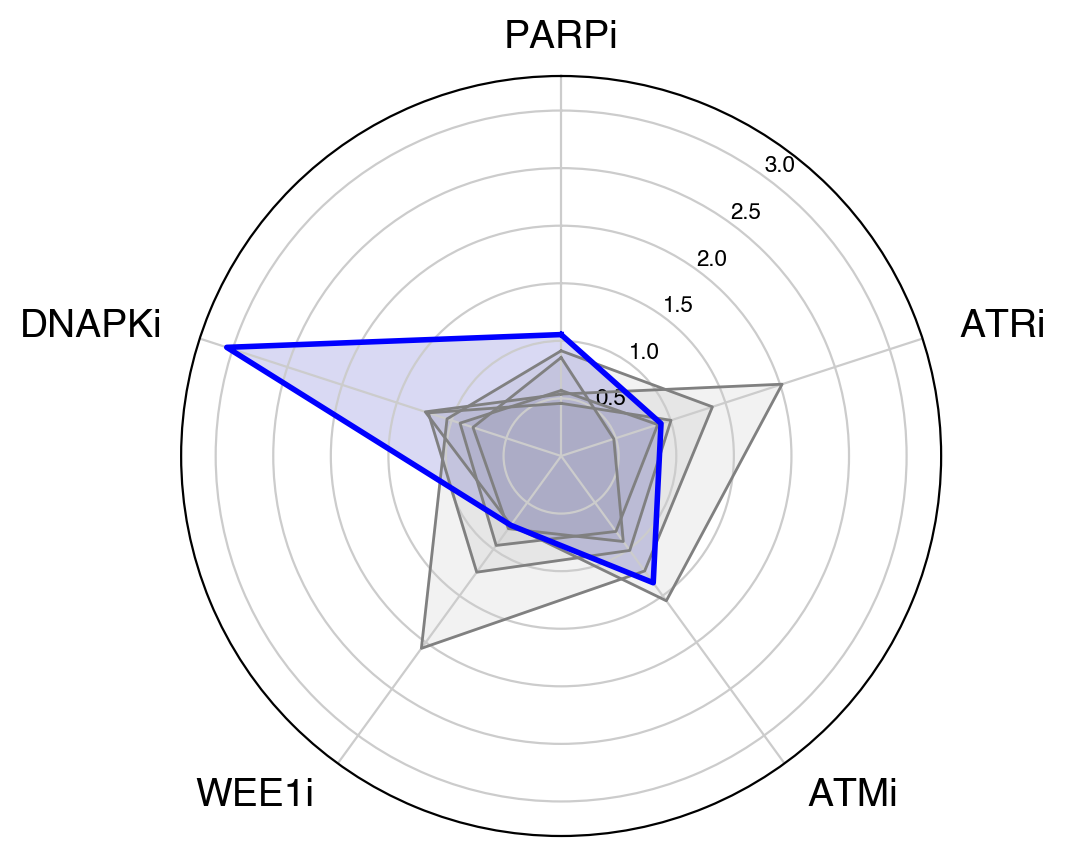

In [19]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True), dpi=100)

angles = draw_radar(ax, single_score_df.abs(), lims = (0,3.3) )

for t in hits_common_sen:
    add_to_radar(ax, single_score_df.abs(), t, 'gray', angles)

add_to_radar(ax, single_score_df.abs(), 'PRDX1', 'b', angles, linewidth=2, alpha=.1)

# ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# fig.tight_layout()

plt.savefig('Fig-X-PRDX1-spiderplot-1.pdf', dpi=600)

___

### Combo treatments

In [20]:
comb_score_df = pd.concat(
    
    dict(
        [
            (res_name, res['score'])
            for res_name, res in result_tables.items()
            if 'rho' in res_name
            if "Pi" in res_name
        ]
    ),
    axis=1
)

comb_score_df = comb_score_df[~comb_score_df.index.str.contains('pseudo_')]

comb_score_df.columns = [drug_names[col.replace('rho:','').replace('_vs_DMSO','')] for col in comb_score_df.columns]

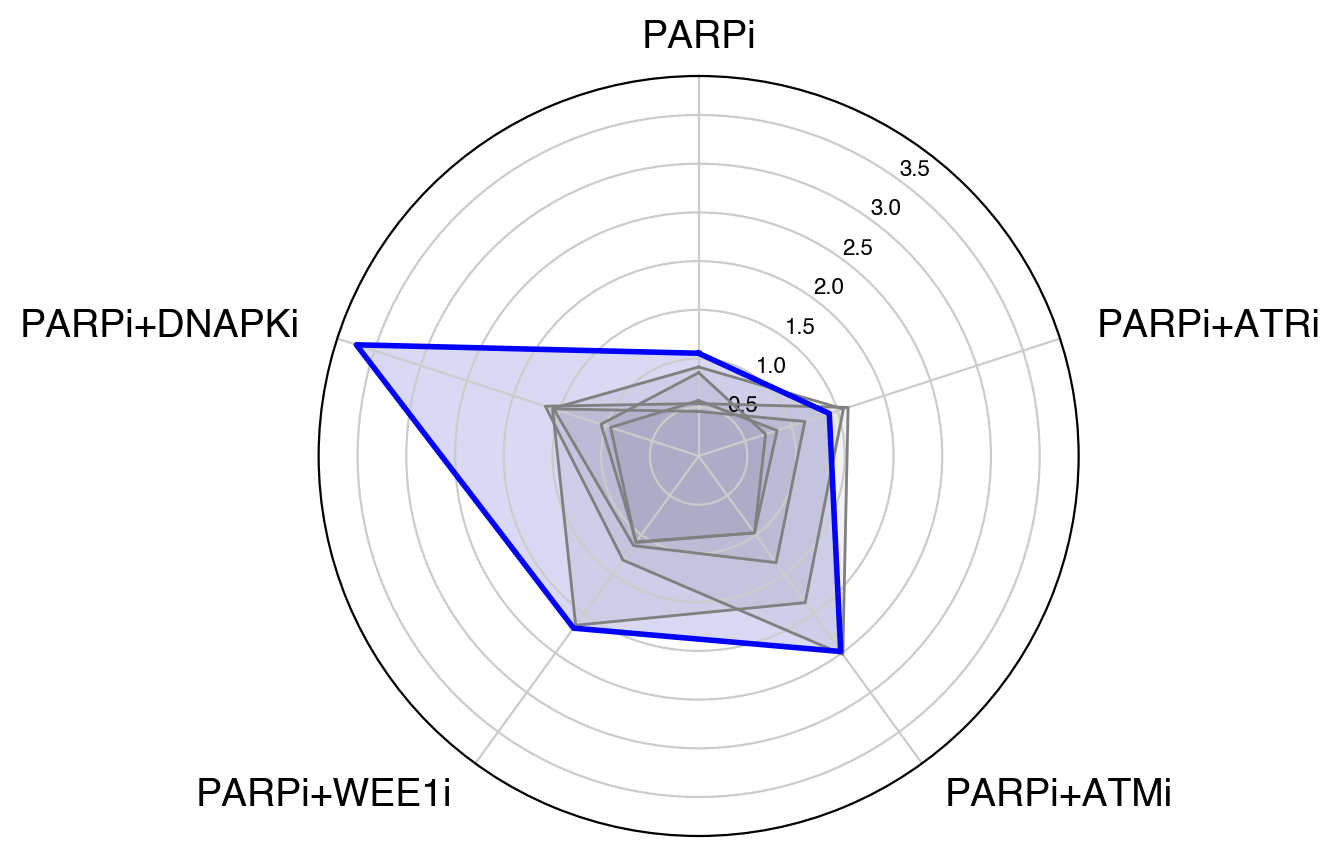

In [21]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True), dpi=100)

angles = draw_radar(ax, comb_score_df.abs(), lims = (0,3.9) )

for t in hits_common_sen:
    add_to_radar(ax, comb_score_df.abs(), t, 'gray', angles)

add_to_radar(ax, comb_score_df.abs(), 'PRDX1', 'b', angles, linewidth=2, alpha=.1)

# ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# fig.tight_layout()
plt.savefig('Fig-X-PRDX1-spiderplot-2.pdf', dpi=600)

___

#### volcano plots

In [22]:
# screen.listPhenotypeScores(run_name='compare_guides')#phenotypes['compare_guides']['results']

In [23]:
# _, axes = plt.subplots(1,3,figsize=(9,3.5),dpi=200,sharey=True)


# for ax, treatment in zip(axes,['Pi','Ki','PiKi']):
#     screen.drawVolcano(
#         run_name='compare_guides',
#         phenotype_name=f'rho:{treatment}_vs_DMSO', 
#         ax=ax, 
#         pvalue_col='ttest pvalue', 
#         threshold=6,
#         sensitivity_hits=['PRDX1'],
#         dot_size=4,
#         size_txt=9,
#         # ylims=[0,9],
#         # xlims=[-3,3],
#     )
#     ax.set_title(drug_names[treatment])


# for ax in axes: 
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.get_legend().remove()
#     ax.grid(False)

# plt.tight_layout()
# plt.show()

In [24]:
# rho_PiKi = scp.ps.annotateScoreTable(
#     screen.phenotypes['compare_guides']['results']['rho:PiKi_vs_DMSO'],
#     up_hit=scp.ps._annotate.hit_dict['rho']['up_hit'],
#     down_hit=scp.ps._annotate.hit_dict['rho']['down_hit'],
#     threshold=6,
#     pvalue_col='ttest pvalue'
# )

# rho_PiKi.groupby('label').size()

#### get result tables

In [58]:
def getAnnotatedTables(screen, threshold):
    return dict([
        (phenotype_name, 
         screen.getPhenotypeScores(
             run_name='compare_guides',phenotype_name=phenotype_name,threshold=threshold, pvalue_col='ttest pvalue'
         ).query('target!="negative_control"').set_index(['target','transcript']))
        for phenotype_name in screen.listPhenotypeScores(run_name='compare_guides')
    ])

In [59]:
annotated_result_table = pd.concat(dict([
    (drug_names[k.split(':')[1].split('_vs_')[0]],table) for k, table in 
    getAnnotatedTables(screen, threshold=6).items()
    if 'rho' in k
]),axis=1).dropna()

### load gsea

Related plots

In [54]:
import seaborn as sns

In [33]:
top_pathways = pd.concat(gsea_results,axis=1).head(25).index

df = pd.concat(gsea_results).reset_index(names=['Inhibitor','Term']).replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

df['-log10(FDR)'] = -np.log10(df['fdr']).astype(int)

df = df.drop_duplicates('leading_edge',keep='first')

df = df[df.Term.isin(top_pathways)]

df.Term = df.Term.str.replace('GOBP_','').str.replace('_',' ').str.lower()

for word in ['dna', 'rna',' i ', 'nadh', 'atp']:
    df.Term = df.Term.str.replace(word,word.upper())

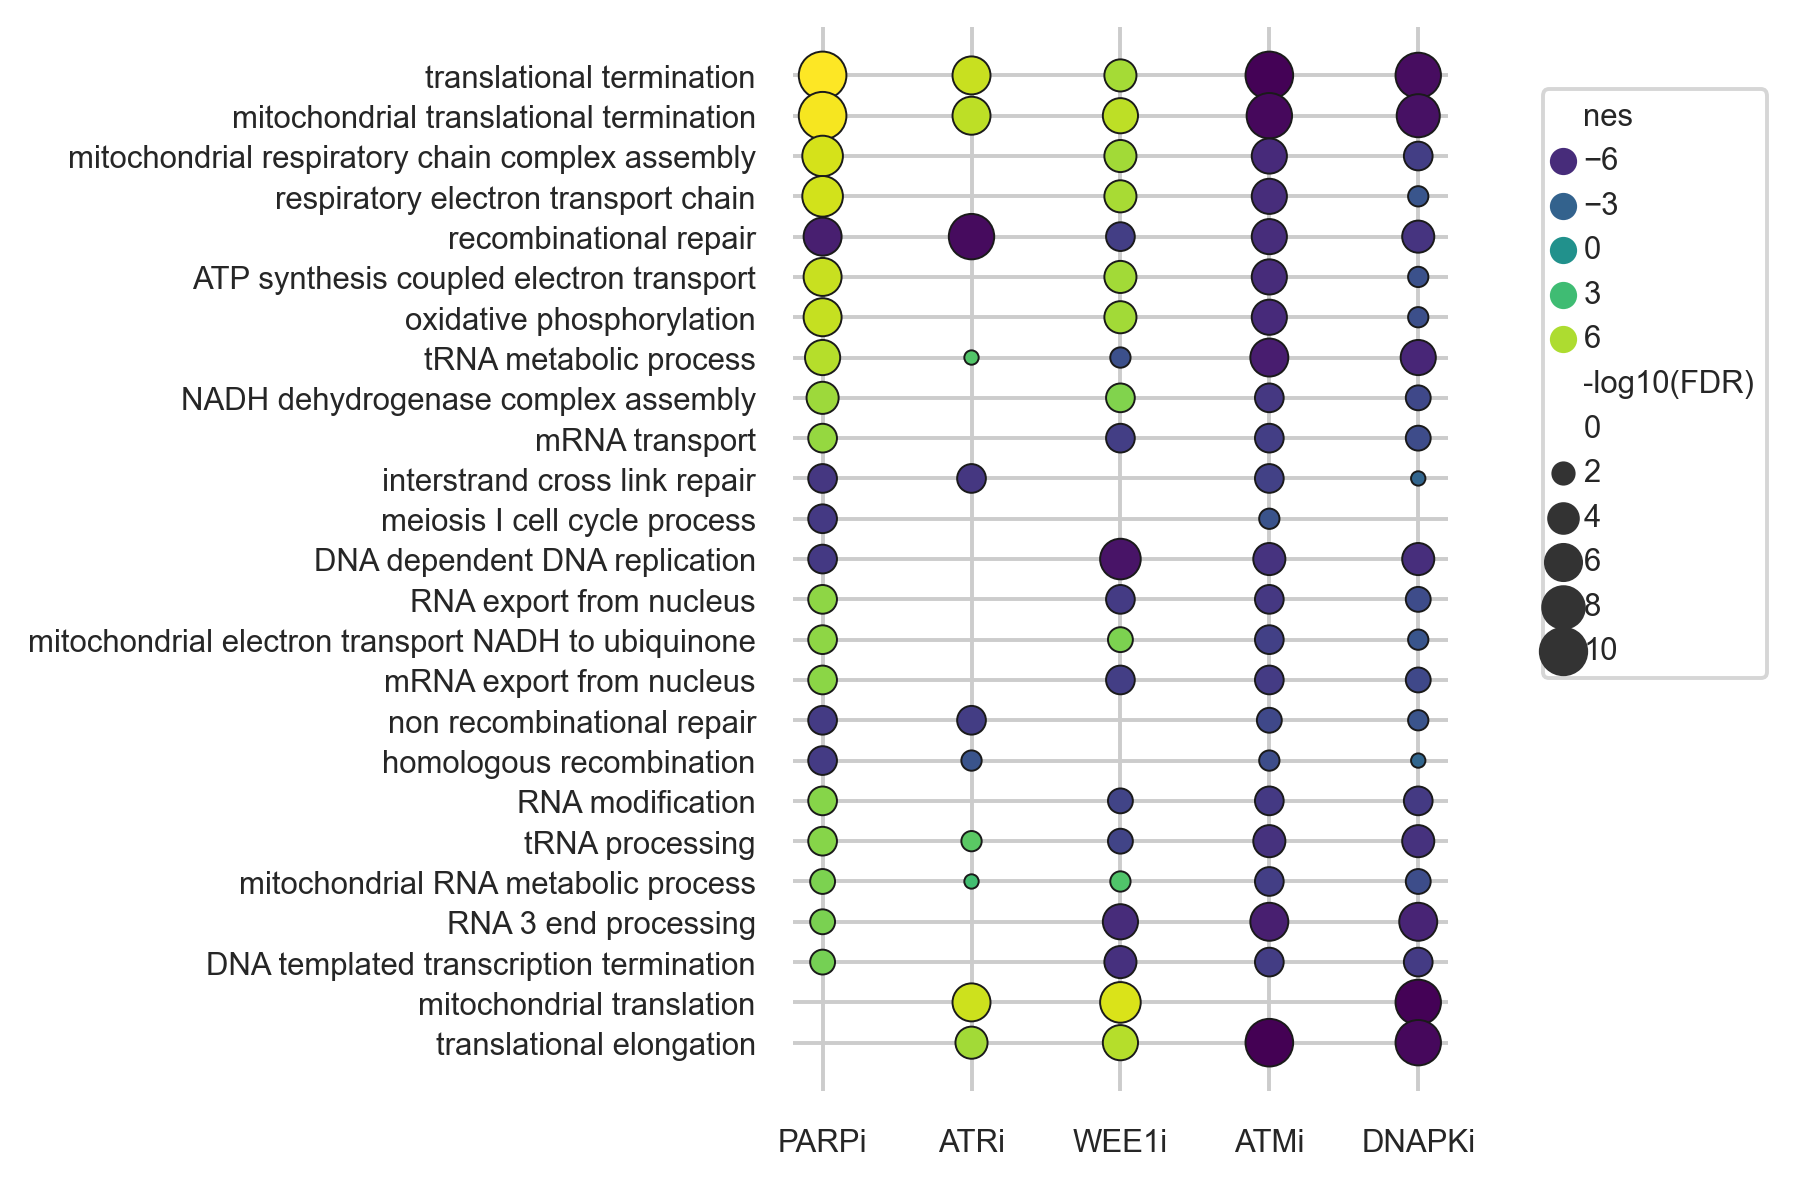

In [55]:
%matplotlib inline
# Set the figure size and style
fig, ax = plt.subplots(figsize=(3, 5))
sns.set(style="whitegrid")

# Create the dot plot
scatter = sns.scatterplot(
    data=df,
    x='Inhibitor',
    y='Term',
    size='-log10(FDR)',
    hue='nes',
    # palette=yellow_blue,#'viridis',
    palette='viridis',
    sizes=(0, 150),
    # alpha=0.7,
    edgecolor='k',
    linewidth=.5,
    ax = ax
)

# Improve the aesthetics
plt.xlabel(None)
plt.ylabel(None)

# Customize the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=2., fontsize=8)

plt.box(False)

for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(8)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)

# Show the plot
plt.savefig('Fig-1E.pdf', dpi=600)
plt.show()

### A geneset!

In [190]:
rho_bin_CELL_REDOX_HOMEOSTASIS = pd.concat(dict([
    (drug_names[res_name.split(':')[1].split('_vs_')[0]], res['combined_score'].le(-6))
    for res_name, res in result_tables.items()
]),axis=1).fillna(False)

rho_bin_CELL_REDOX_HOMEOSTASIS = rho_bin_CELL_REDOX_HOMEOSTASIS.loc[list(set(c5_gobp_gmt['GOBP_CELL_REDOX_HOMEOSTASIS']) & set(rho_bin_CELL_REDOX_HOMEOSTASIS.index)),:]

rho_bin_CELL_REDOX_HOMEOSTASIS = rho_bin_CELL_REDOX_HOMEOSTASIS.loc[rho_bin_CELL_REDOX_HOMEOSTASIS.sum(axis=1).sort_values(ascending=False).index.to_list(),:]

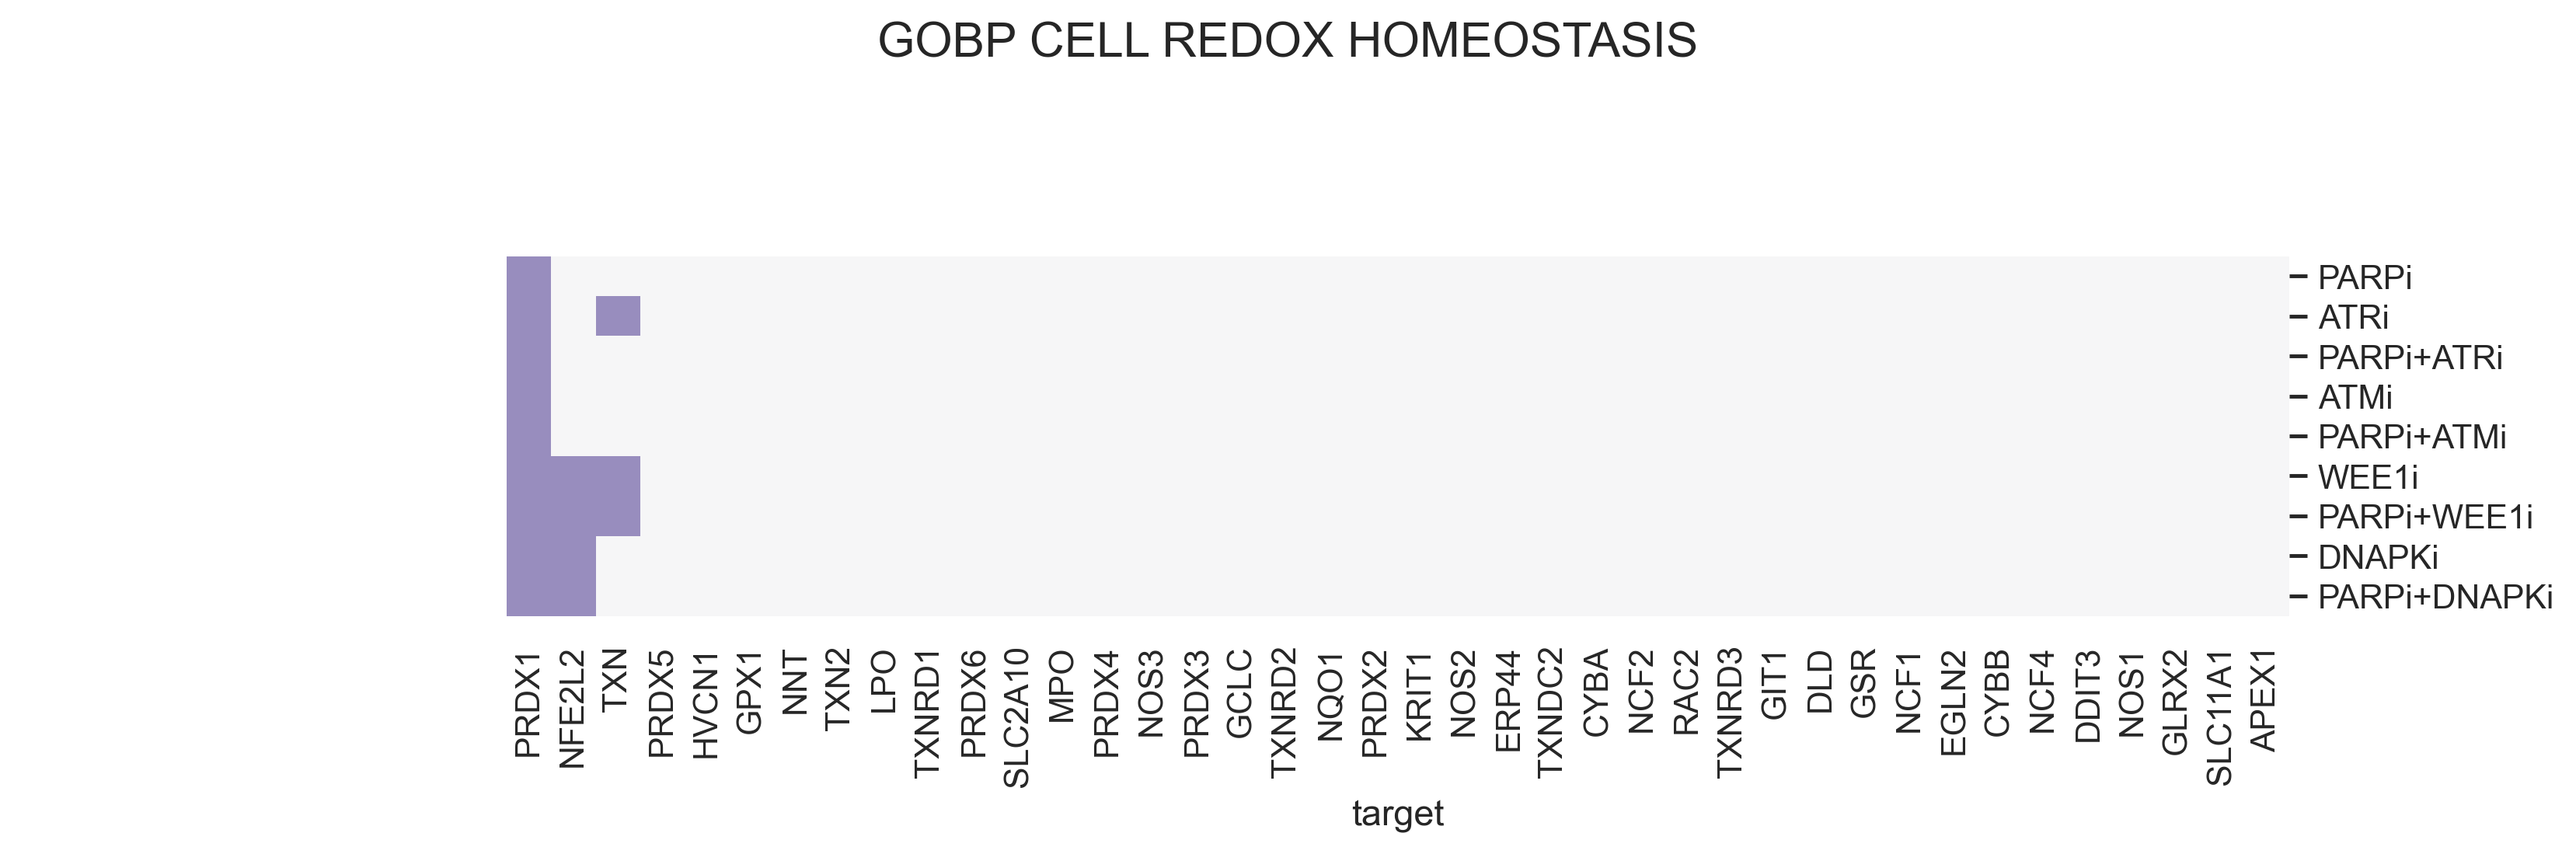

In [200]:
g = sns.clustermap(
    rho_bin_CELL_REDOX_HOMEOSTASIS.T,
    cmap='PuOr',#,#'RdBu_r',
    vmin=-2,
    vmax=2,
    row_cluster=False,
    col_cluster=False,
    # dendrogram_ratio=0.1,
    # cbar_kws={'shrink': .5},
    figsize=(12,4),
)

g.fig.suptitle('GOBP CELL REDOX HOMEOSTASIS',size=16) 
g.cax.set_visible(False)

g.ax_col_dendrogram.set_visible(False)

plt.tight_layout()
g.savefig('Fig-3A.pdf')
plt.show()

### save to file

? how we want to organize the results for the manuscript tables (!)

- Tom also asked for gamma scores.

In [ ]:
# with pd.ExcelWriter('A549_CRISPRi_screen_analysis.xlsx', engine='openpyxl') as writer:
#     screen.adata.obs.to_excel(writer, sheet_name='sample sheet')
#     screen.adata.to_df(layer='raw_counts').astype(int).T.to_excel(writer, sheet_name='raw counts')
#     screen.adata.to_df(layer='seq_depth_norm').astype(int).T.to_excel(writer, sheet_name='normalized counts')
#     .to_excel(writer, sheet_name='guide-level scores')
#     annotated_result_table.to_excel(writer, sheet_name='gene-level scores')
#     pd.concat(gsea_results,axis=1).to_excel(writer, sheet_name='GSEA')

Table-S1

In [66]:
with pd.ExcelWriter('tables/Table-S1.xlsx', engine='openpyxl') as writer:
    crispri_v2_screen_result_tables.to_excel(writer, sheet_name='Gene Level Phenotypes')
    pd.concat(crispri_v2_screen_gsea_results,axis=1).to_excel(writer, sheet_name='GO GSEA Analysis')

Table S2

In [67]:
with pd.ExcelWriter('tables/Table-S2.xlsx', engine='openpyxl') as writer:
    crispra_v2_screen_result_tables.to_excel(writer, sheet_name='Gene Level Phenotypes')
    pd.concat(crispra_v2_screen_gsea_results,axis=1).to_excel(writer, sheet_name='GO GSEA Analysis')

___

In [94]:
# import datetime
# from matplotlib.backends.backend_pdf import PdfPages

# with PdfPages('CRISPRi-PRDX1-DDRi-screens.pdf') as pdf:
#     for fig in [fig1,fig2,fig3,fig4,fig5,fig6,fig7,fig8,fig9,fig10,fig11]:
#         pdf.savefig(fig)  # saves the current figure into a pdf page

#     d = pdf.infodict()
#     d['Title'] = 'ScreenPro2 plots'
#     d['ModDate'] = datetime.datetime.today()

# 

In [52]:
%reload_ext watermark

In [53]:
%watermark

Last updated: 2024-09-24T23:44:19.957625-07:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.27.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.0-119-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [54]:
%watermark --iversions

screenpro : 0.4.15
matplotlib: 3.6.2
scanpy    : 1.10.3
anndata   : 0.10.9
blitzgsea : 1.3.47
pandas    : 1.5.3
numpy     : 1.26.4



___